In [1]:
# -------------------------
# 1. Imports
# -------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

sns.set(style='whitegrid')

In [2]:
# -------------------------
# 2. Set Paths
# -------------------------
project_root = os.path.dirname(os.getcwd())
raw_folder = os.path.join(project_root, "data", "raw")
processed_folder = os.path.join(project_root, "data", "processed")
os.makedirs(processed_folder, exist_ok=True)

file_path = os.path.join(raw_folder, "employee_data.csv")
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Raw dataset not found at: {file_path}")

df = pd.read_csv(file_path)
print("Raw dataset loaded.")

Raw dataset loaded.


In [3]:
# -------------------------
# 3. Target Variable
# -------------------------
target = "Attrition"
if target not in df.columns:
    raise ValueError(f"Target '{target}' not found in dataset.")

# Encode target: 1 = Yes (Attrition), 0 = No
y = df[target].map({'Yes': 1, 'No': 0})
X = df.drop(columns=[target])

print(f"Target distribution:\n{y.value_counts(normalize=True)}")

Target distribution:
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64


In [4]:

# -------------------------
# 4. Identify Column Types
# -------------------------
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
print(f"Numeric cols: {numeric_cols}")
print(f"Categorical cols: {categorical_cols}")

Numeric cols: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical cols: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


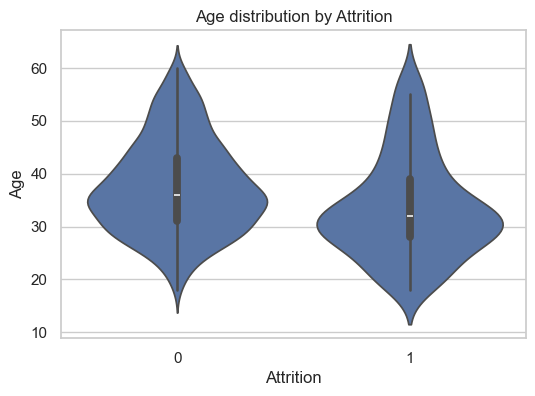

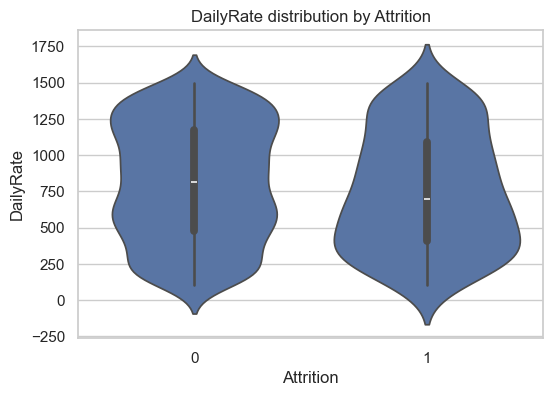

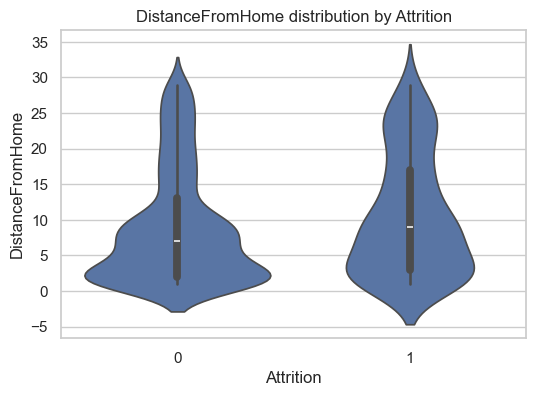

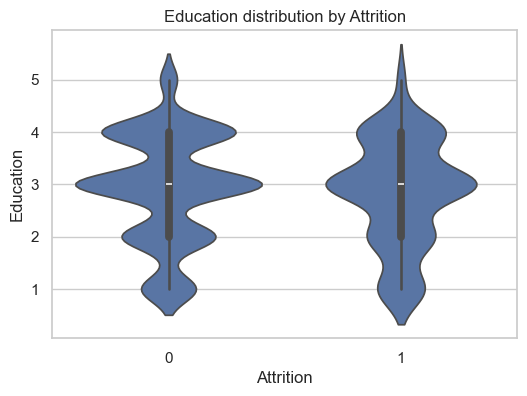

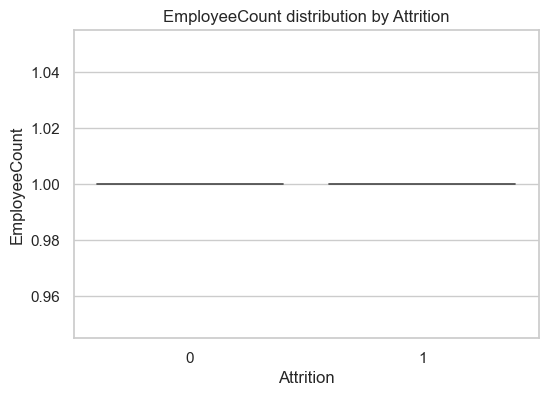

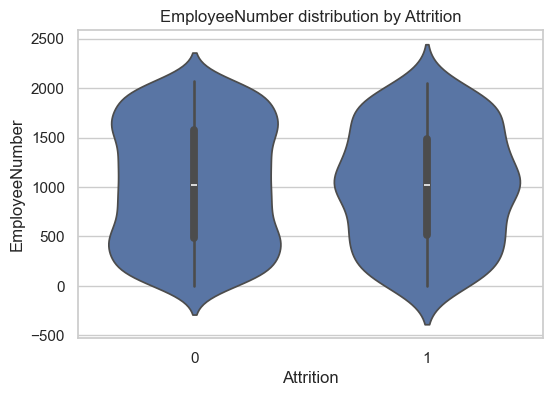

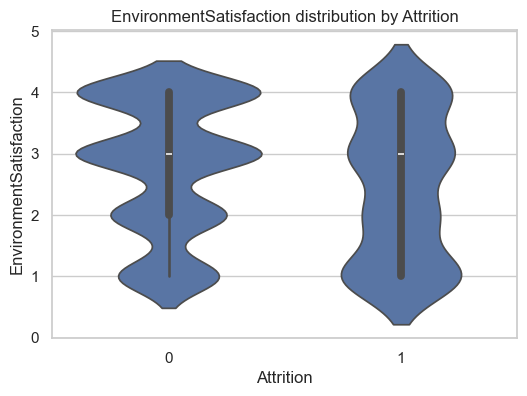

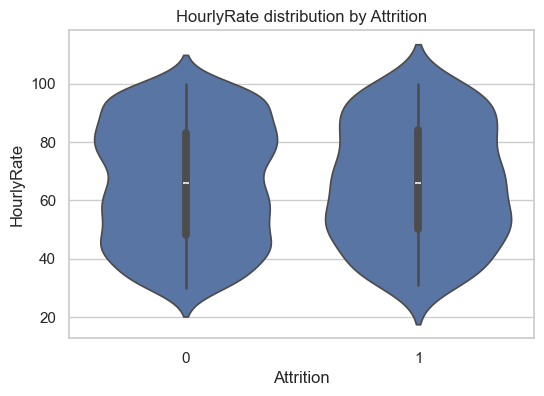

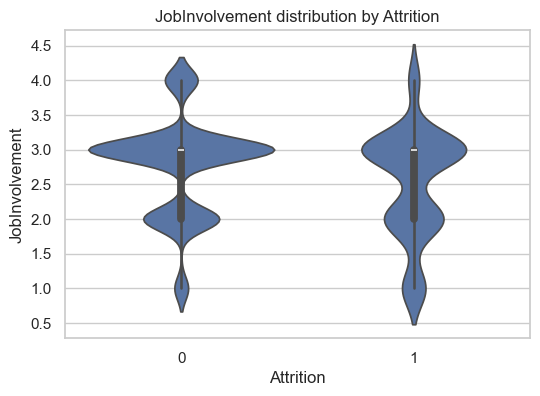

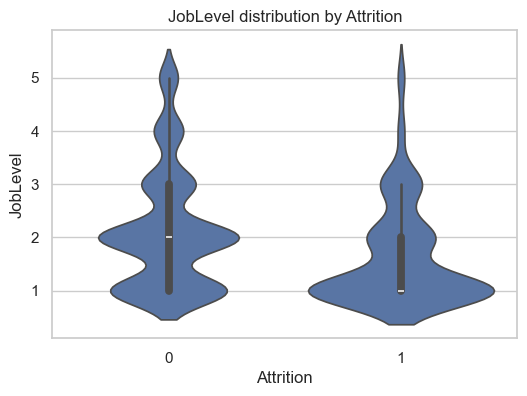

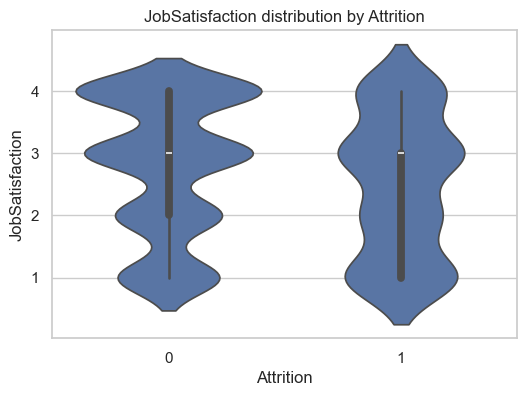

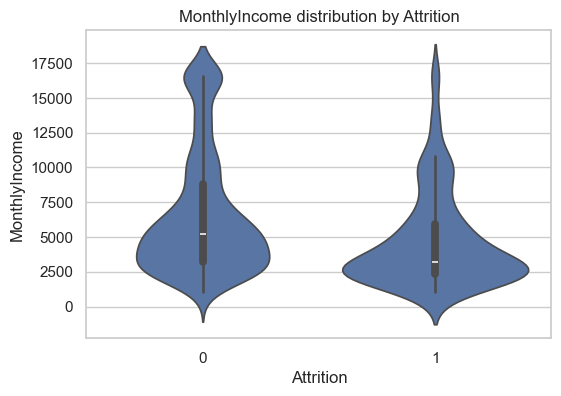

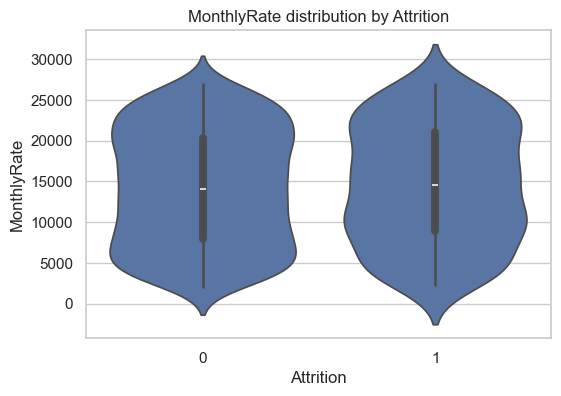

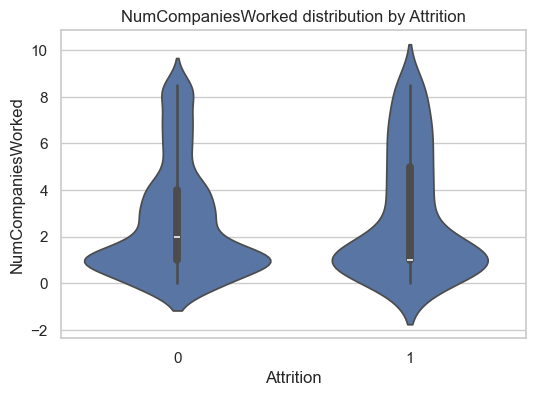

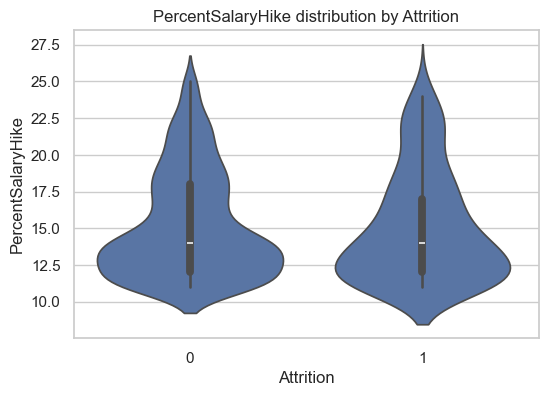

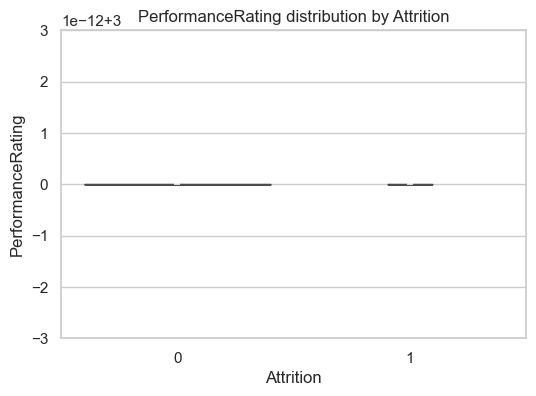

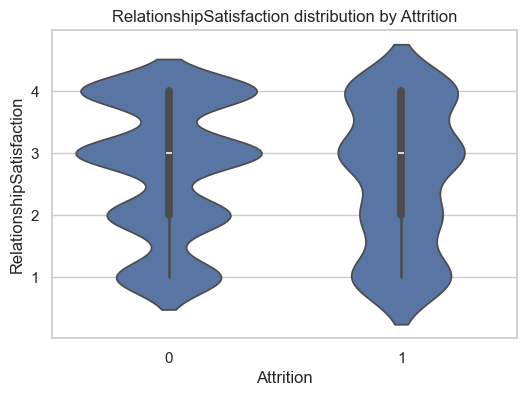

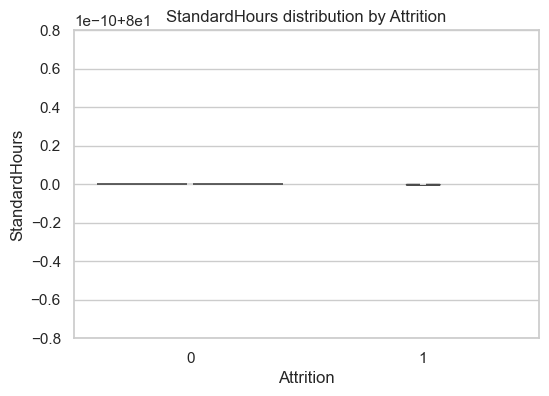

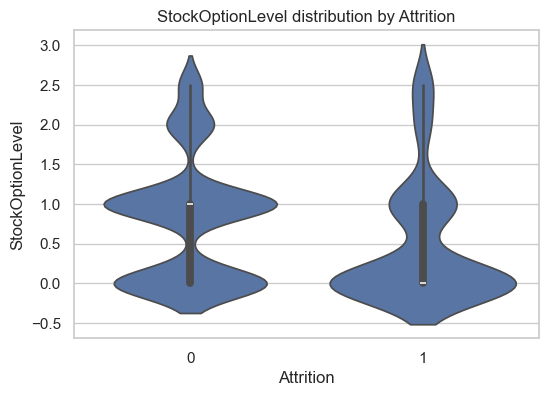

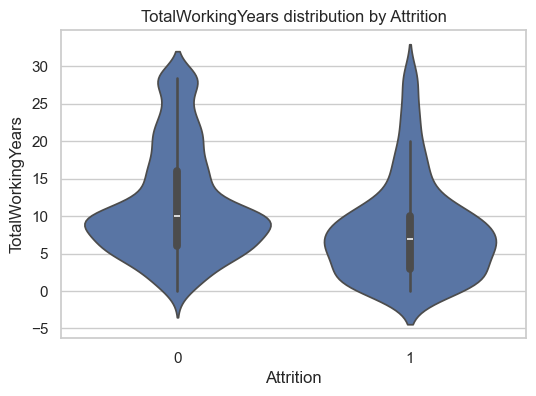

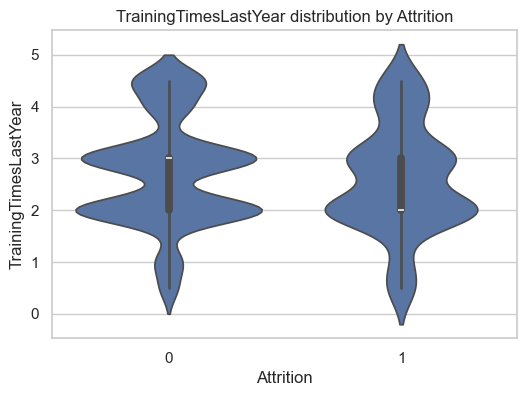

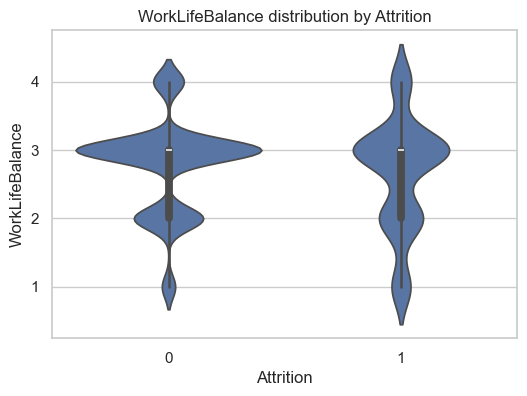

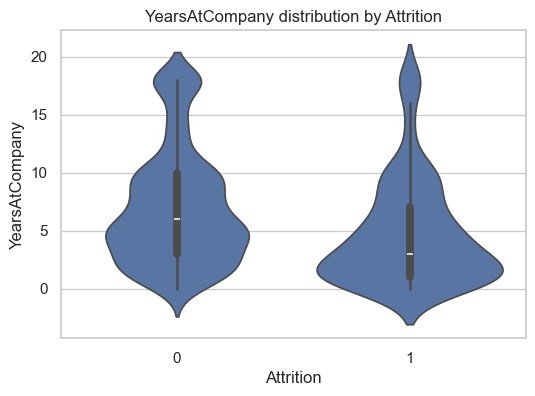

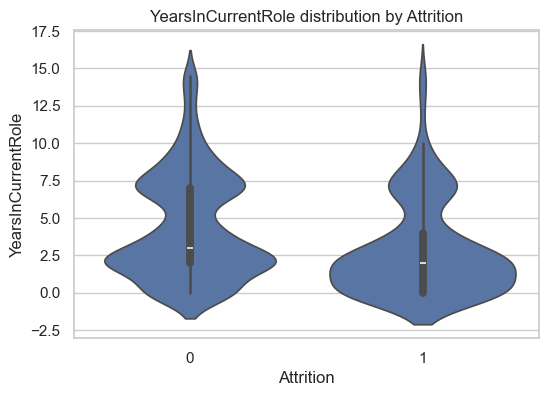

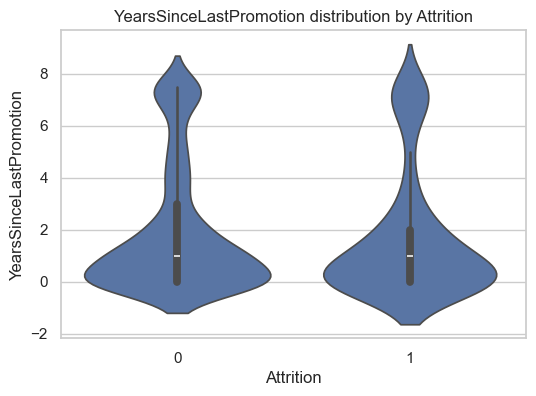

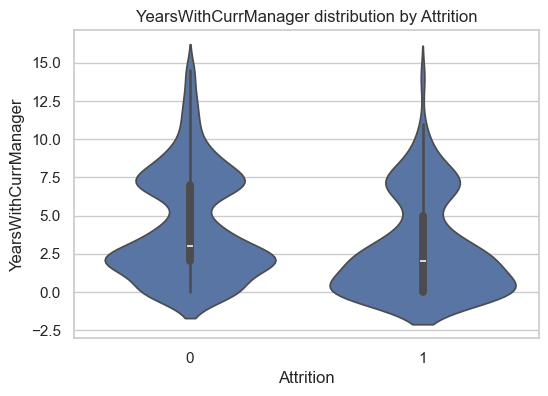

In [5]:
# -------------------------
# 5. Outlier Handling
# -------------------------
for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    X[col] = np.clip(X[col], lower, upper)  # cap outliers

# Visualize distributions by target
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.violinplot(x=y, y=X[col])
    plt.title(f"{col} distribution by Attrition")
    plt.show()

In [6]:
# -------------------------
# 6. Class Imbalance Check
# -------------------------
print("Class distribution after encoding:")
print(y.value_counts(normalize=True))

Class distribution after encoding:
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64


In [7]:
# -------------------------
# 7. Missing Value Indicators
# -------------------------
missing_cols = [col for col in X.columns if X[col].isnull().sum() > 0]
for col in missing_cols:
    X[col + "_missing"] = X[col].isnull().astype(int)
print(f"Missing indicators added for: {missing_cols}")

Missing indicators added for: []


In [8]:
# -------------------------
# 8. Impute, Encode, Scale
# -------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="passthrough"  # keep missing indicators
)

X_clean = preprocessor.fit_transform(X)

# Build DataFrame with correct column names
encoded_cat_cols = preprocessor.named_transformers_["cat"]["encoder"].get_feature_names_out(categorical_cols)
clean_feature_names = numeric_cols + list(encoded_cat_cols) + [col for col in X.columns if col.endswith("_missing")]
X_clean_df = pd.DataFrame(X_clean, columns=clean_feature_names)

print(f"Final cleaned shape: {X_clean_df.shape}")
X_clean_df.head()


Final cleaned shape: (1470, 55)


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,0.446350,0.742527,-1.010909,-0.891688,0.0,-1.701283,-0.660531,1.383138,0.379672,-0.057788,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,1.322365,-1.297775,-0.147150,-1.868426,0.0,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.008343,1.414363,-0.887515,-0.891688,0.0,-1.696298,1.169781,1.284725,-1.026167,-0.961486,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,-0.429664,1.461466,-0.764121,1.061787,0.0,-1.694636,1.169781,-0.486709,0.379672,-0.961486,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,-1.086676,-0.524295,-0.887515,-1.868426,0.0,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [9]:
# -------------------------
# 9. Train/Test Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_clean_df, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1176, 55), Test shape: (294, 55)


In [10]:
# -------------------------
# 10. Save Processed Data
# -------------------------
X_train.to_csv(os.path.join(processed_folder, "train.csv"), index=False)
X_test.to_csv(os.path.join(processed_folder, "test.csv"), index=False)
y_train.to_csv(os.path.join(processed_folder, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(processed_folder, "y_test.csv"), index=False)

print("Processed train/test datasets saved.")

Processed train/test datasets saved.
